<a href="https://colab.research.google.com/github/terryspitz/ipython_notebooks/blob/master/deeperfont_tri_data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
#jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888
from enum import Enum, IntEnum
import math
import os
import glob
import xml.etree.ElementTree as ET
import numpy as np
from PIL import Image, ImageDraw, ImageChops
from IPython.display import display
print(np.__version__)
print(tf.__version__)
np.set_printoptions(precision=2)

import matplotlib.pyplot as plt
#!pip install triangle
import triangle as tr

#!pip install fonttools
from fontTools.ttLib import TTFont


1.14.2
1.10.0


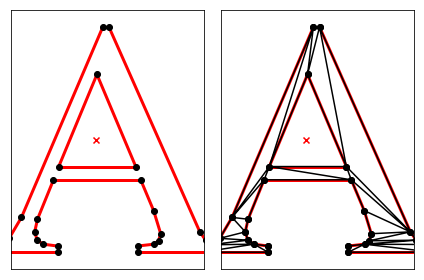

In [20]:
# Sample from https://rufat.be/triangle/API.html

#A = dict(vertices=np.array(((0, 0), (1, 0), (1, 1), (0, 1))))
A = tr.get_data('A')
B = tr.triangulate(A, opts='p')
#plt.figure()
ax1 = plt.subplot(121)
tr.plot(ax1, **A)
lim = ax1.axis()
ax2 = plt.subplot(122, sharey=ax1)
tr.plot(ax2, **B)
ax2.axis(lim)
plt.tight_layout()
plt.show()

In [0]:
#Read Font outlines from local font files and write outlines to file for fitting

def getCoordinates(font:TTFont, glyphName:str):
    """font, glyphName --> glyph coordinates as expected by "gvar" table
    The result includes four "phantom points" for the glyph metrics,
    as mandated by the "gvar" spec.
    Function from https://github.com/fonttools/fonttools/blob/master/Snippets/interpolate.py
    By inspection coords[0] are all points, and coords[1] are the end of the ranges for each contour (shape)
    """
    glyphTable = font["glyf"]
    glyph = glyphTable.glyphs.get(glyphName)
    if glyph is None:
        return None
    glyph.expand(glyphTable)
    glyph.recalcBounds(glyphTable)
    coords = glyph.getCoordinates(glyphTable)
    start=0
    contours = []
    for end in coords[1]:
        contours.append(coords[0][start:end+1])
        start=end+1
    return contours

def generateOutlines(fontfile:str, glyphs:str, max_outline_points:int):
    """
    Read the actual points from all glyphs in the font into numpy array.
    Output is array of glyphs x points x coords
    We use float not the original ints from the font - according to https://github.com/fchollet/keras/issues/2218.
    """
    font = TTFont(fontfile)
    unitsPerEm = font['head'].unitsPerEm *0.7
    vertices = np.zeros((len(glyphs), max_outline_points, 2), np.float32)
    segments = np.full((len(glyphs), max_outline_points, 2), -1, np.int32)
    maxj = 0
    for i, letter in enumerate(glyphs):
      j = 0
      contours = getCoordinates(font, letter)
      startp = (0,0)
      startj = 0
      #ttx contours are polygons within the glyph, like the outside and inside outlines of an O
      for xy in contours:
        #startp = xy[0]
        startj = j
        #vertices[i,j,0] = (xy[0][0]-startp[0])/ unitsPerEm
        #vertices[i,j,1] = (xy[0][1]-startp[1])/ unitsPerEm
        vertices[i,j,0] = xy[0][0]/unitsPerEm
        vertices[i,j,1] = xy[0][1]/unitsPerEm
        j = j+1
        #segments between points
        for n in range(len(xy)-1):
          #outlines[j,Stroke.DX] = (xy[n+1][0]-xy[n][0])/ unitsPerEm
          #outlines[j,Stroke.DY] = (xy[n+1][1]-xy[n][1])/ unitsPerEm
          vertices[i,j,0] = xy[n+1][0]/unitsPerEm
          vertices[i,j,1] = xy[n+1][1]/unitsPerEm
          segments[i,j,0] = j-1
          segments[i,j,1] = j
          j = j+1
          if j>=max_outline_points:
            print("Exceeded max_outline_points for: %s in %s" % (letter, fontfile))
            break
        #Add segment from last point to first in contour
        #outlines[j,Stroke.DX] = (xy[0][0]-xy[-1][0])/ unitsPerEm
        #outlines[j,Stroke.DY] = (xy[0][1]-xy[-1][1])/ unitsPerEm
        segments[i,j,0] = j-1
        segments[i,j,1] = startj
        if j>maxj: maxj=j
    print("Font %s has max %d points" % (fontfile, maxj))
    return vertices, segments
  
def readFonts(files: [str], glyphs: str, max_outline_points:int):
    print('loading {} files'.format(len(files)))
    vertices_stack, segments_stack = [], []
    for i, fontfile in enumerate(files):
      vertices, segments = generateOutlines(fontfile, glyphs, max_outline_points)
      vertices_stack.append(vertices)
      segments_stack.append(segments)
    return np.stack(vertices_stack), np.stack(segments_stack)


In [78]:
print('setup...')
glyphs = [chr(i) for i in range(ord('A'), ord('Z')+1)]
glyphs += [chr(i) for i in range(ord('a'), ord('z')+1)]
glyphs += ['zero','one','two','three','four','five','six','seven','eight','nine']
#glyphs = ['A','B','a','b','one','two']
#glyphs = ['one','two','one','two']
#glyphs = ['A'] + glyphs
glyphs = ['A','B','i','g','eight']
max_outline_points = 200
files = glob.glob('deeper/fonts/*.ttf')
vertices, segments = readFonts(files, glyphs, max_outline_points)
print("outline shape (fonts, glyphs, max_points_per_font, coords): ", vertices.shape)


setup...
loading 8 files
Font deeper/fonts\AndikaNewBasic-B.ttf has max 106 points
Font deeper/fonts\AndikaNewBasic-BI.ttf has max 113 points
Font deeper/fonts\AndikaNewBasic-I.ttf has max 116 points
Font deeper/fonts\AndikaNewBasic-R.ttf has max 110 points
Font deeper/fonts\Courier Prime Bold Italic.ttf has max 70 points
Font deeper/fonts\Courier Prime Bold.ttf has max 72 points
Font deeper/fonts\Courier Prime Italic.ttf has max 74 points
Font deeper/fonts\Courier Prime.ttf has max 80 points
outline shape (fonts, glyphs, max_points_per_font, coords):  (8, 5, 200, 2)


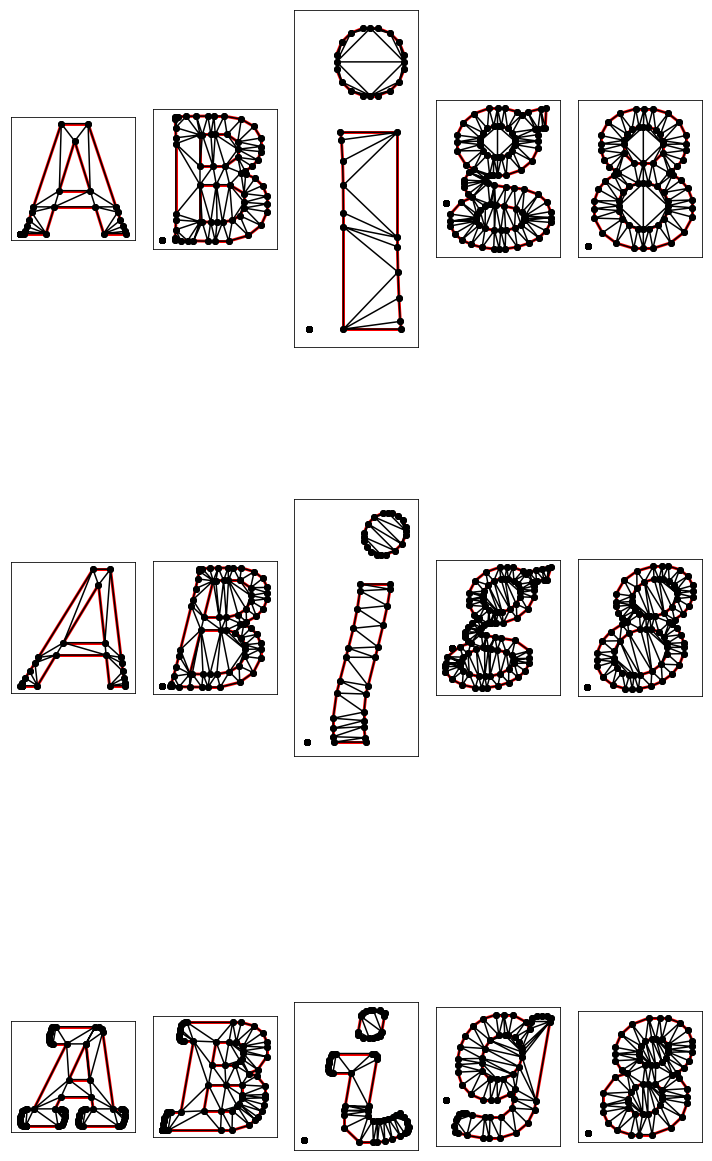

In [83]:
plt.figure(figsize=(10,20))
fonts=2
glyphs=4
for font in range(fonts+1):
  for glyph in range(glyphs+1):
    ax = plt.subplot(fonts+1, glyphs+1, 1+font*(glyphs+1)+glyph)
    verts = vertices[font*2,glyph]
    segs = segments[font*2,glyph]
    segs = segs[segs>=0].reshape((-1,2))
    #tr.plot(ax, vertices=vertices[font,glyph], segments=segs)
    tris = tr.triangulate({"vertices": verts, "segments": segs}, opts='p')
    tr.plot(ax, **tris)

    #ax2.axis(lim)
plt.tight_layout()
plt.show()
